In [1]:
import glob
import os
import re

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import sklearn.metrics as metrics
import umap
import umap.plot

from data_loader import *
from feature_spectrum import *
from model import *
from model_utils import set_seed
from train import *
from visualization import *
set_seed(1123)

/home/yusri/Programs/miniforge3/envs/vqvae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yusri/Programs/miniforge3/envs/vqvae/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/yusri/Programs/miniforge3/envs/vqvae/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/yusri/Program

In [2]:
def load_model(model_path, input_dim, n_class, data_dir=""):
    model_weights = torch.load(os.path.join(data_dir, model_path))
    input_list = re.split("[_]", model_path)
    hyperparam_dict = {}

    # Iterate through the list
    for item in input_list:
        if ":" in item:
            key, value = item.split(":")

            # Handle specific key-value assignments
            if key == "fsq":
                hyperparam_dict["fsq"] = value == "True"
            elif key == "ema":
                hyperparam_dict["ema"] = value == "True"
            elif key == "supervised":
                hyperparam_dict["supervised"] = value == "True"
            elif key == "codes":
                hyperparam_dict["num_embeddings"] = int(value)
            elif key == "split":
                hyperparam_dict["split"] = int(value)
            elif key == "cost":
                hyperparam_dict["commitment_cost"] = float(value)
            elif key == "epochs":
                hyperparam_dict["n_epochs"] = int(value)
            elif key == "lr":
                # Strip '.pt' and convert to float
                hyperparam_dict["lr"] = float(value.replace(".pt", ""))
            elif "encoder" in item:
                # Extract hidden_dim1, hidden_dim2, and embedding_dim from the encoder string
                dims = re.findall(r"\d+", item)
                hyperparam_dict["hidden_dim1"] = int(dims[0])
                hyperparam_dict["hidden_dim2"] = int(dims[1])
                hyperparam_dict["embedding_dim"] = int(dims[2])

    model = VQClassifier(
        input_dim=input_dim,
        n_class=n_class,
        hidden_dim1=hyperparam_dict["hidden_dim1"],
        hidden_dim2=hyperparam_dict["hidden_dim2"],
        num_embeddings=hyperparam_dict["num_embeddings"],
        embedding_dim=hyperparam_dict["embedding_dim"],
        commitment_cost=hyperparam_dict["commitment_cost"],
        split=hyperparam_dict["split"],
        fsq=hyperparam_dict["fsq"],
        levels=[3] * (hyperparam_dict["embedding_dim"] // hyperparam_dict["split"]),
        ema=hyperparam_dict["ema"],
        decay=0.99,
        epsilon=1e-5,
        dropout=0.1,
    )
    model.load_state_dict(model_weights)
    model.eval()
    return model

In [3]:
model_paths = [x for x in os.listdir("model") if ("3khvg_split_train_fsq:False" in x) and ("supervised:True" in x) and ("num_codes:200" in x)]
device = "cpu"

In [4]:
model_paths

['model_thymus_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt',
 'model_pbmc_68k_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt',
 'model_lung_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt',
 'model_pancreas_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt']

In [5]:
model_dict = {}
data_dict = {}
data_dir = "data"
for model_path in model_paths:
    data_path = model_path.split(":", 1)[0]
    data_path = data_path.replace("model_", "").replace("train_fsq", "test") + ".h5ad"
    print(data_path)
    adata = sc.read_h5ad(os.path.join(data_dir, data_path))
    input_dim = adata.shape[1]
    n_class = len(np.unique(adata.obs.cell_type.unique()))
    model = load_model(model_path, input_dim, n_class, data_dir="model")
    model_dict[model_path] = model.to(device)
    data_dict[data_path] = adata

thymus_3khvg_split_test.h5ad


/tmp/ipykernel_5522/716742169.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(data_dir, model_path))


pbmc_68k_3khvg_split_test.h5ad
lung_3khvg_split_test.h5ad


/tmp/ipykernel_5522/716742169.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(data_dir, model_path))
/tmp/ipykernel_5522/71674216

pancreas_3khvg_split_test.h5ad


/tmp/ipykernel_5522/716742169.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(data_dir, model_path))


In [6]:
acc_scores = {}
f1_scores = {}
for key, model in model_dict.items():
    data_path = key.split(":", 1)[0]
    data_path = data_path.replace("model_", "").replace("train_fsq", "test") + ".h5ad"
    adata = data_dict[data_path]
    test_set = GeneDataset(adata, target="target")
    n_class = model.classifier.linear1.out_features
    with torch.no_grad():
        model.eval()
        model_prediction = model.predict(test_set.genes.to(device))
        model_prediction = torch.argmax(model_prediction, axis=1).detach().cpu().numpy()
        acc = metrics.accuracy_score(test_set.labels, model_prediction)
        f1_score = metrics.f1_score(test_set.labels, model_prediction, average="macro")
        acc_scores[key] = acc
        f1_scores[key] = f1_score

In [7]:
acc_scores

{'model_thymus_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt': 0.9262381218557854,
 'model_pbmc_68k_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt': 0.8332600732600732,
 'model_lung_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt': 0.927167358446237,
 'model_pancreas_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt': 0.9821455821761026}

In [8]:
f1_scores

{'model_thymus_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt': np.float64(0.8358282260156534),
 'model_pbmc_68k_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt': np.float64(0.7244624546700613),
 'model_lung_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt': np.float64(0.929121046126294),
 'model_pancreas_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt': np.float64(0.9651595528061199)}

In [9]:
model_dict = {}
data_dict = {}
data_dir = "data"
for model_path in model_paths:
    data_path = model_path.split(":", 1)[0]
    data_path = data_path.replace("model_", "").replace("train_fsq", "train") + ".h5ad"
    print(data_path)
    adata = sc.read_h5ad(os.path.join(data_dir, data_path))
    input_dim = adata.shape[1]
    n_class = len(np.unique(adata.obs.cell_type.unique()))
    model = load_model(model_path, input_dim, n_class, data_dir="model")
    model_dict[model_path] = model.to(device)
    data_dict[data_path] = adata

thymus_3khvg_split_train.h5ad


/tmp/ipykernel_5522/716742169.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(data_dir, model_path))


pbmc_68k_3khvg_split_train.h5ad


/tmp/ipykernel_5522/716742169.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(data_dir, model_path))


lung_3khvg_split_train.h5ad


/tmp/ipykernel_5522/716742169.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(data_dir, model_path))


pancreas_3khvg_split_train.h5ad


/tmp/ipykernel_5522/716742169.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(data_dir, model_path))


In [10]:
for (key, model) in model_dict.items():
    data_path = key.split(":", 1)[0]
    data_path = data_path.replace("model_", "").replace("train_fsq", "train") + ".h5ad"
    adata = data_dict[data_path]
    X_train = adata.X
    if scipy.sparse.issparse(X_train):
            X_train = X_train.toarray()
    with torch.no_grad():
        model.eval()
        _, model_quantized, encoding_indices = model.embed(
            torch.tensor(X_train, dtype=torch.float32).to(device)
        )
        adata.obsm["X_emb_quantized"] = model_quantized.detach().cpu().numpy()
        adata.obsm["encoding_indices"] = encoding_indices.detach().cpu().numpy()
    #     adata.obsm["X_emb"] = model_embedding.detach().cpu().numpy()
    
    

In [11]:
for (key, adata) in data_dict.items():
    use_rep = "X_emb_quantized"
    sc.pp.neighbors(adata,use_rep=use_rep)
    sc.tl.leiden(adata, flavor="igraph", resolution= 0.5, n_iterations=2)
    sc.tl.umap(adata,min_dist=0.1)

In [12]:
ari_res ={}
ami_res ={}
calinski_harabasz_scores ={}

for (key, adata) in data_dict.items():
    print(key)
    labels_true = adata.obs.cell_type
    labels_pred= adata.obs.leiden
    ari = metrics.adjusted_rand_score(labels_true, labels_pred)
    ami = metrics.adjusted_mutual_info_score(labels_true, labels_pred)
    calinski_harabasz=metrics.calinski_harabasz_score(adata.X.A, labels_pred)
    print(ari)
    print(ami)
    print(calinski_harabasz)

    ari_res[key] = ari
    ami_res[key] = ami
    calinski_harabasz_scores[key] = calinski_harabasz

thymus_3khvg_split_train.h5ad
0.4667603031401885
0.7819175296130907
1742.971
pbmc_68k_3khvg_split_train.h5ad
0.6000686435383776
0.7292526982116437
947.9392
lung_3khvg_split_train.h5ad
0.9760849493337536
0.9660399997330944
210.82086
pancreas_3khvg_split_train.h5ad
0.8299618589519963
0.9312869096505745
168.07703


In [13]:
ari_res

{'thymus_3khvg_split_train.h5ad': 0.4667603031401885,
 'pbmc_68k_3khvg_split_train.h5ad': 0.6000686435383776,
 'lung_3khvg_split_train.h5ad': 0.9760849493337536,
 'pancreas_3khvg_split_train.h5ad': 0.8299618589519963}

In [14]:
ami_res

{'thymus_3khvg_split_train.h5ad': np.float64(0.7819175296130907),
 'pbmc_68k_3khvg_split_train.h5ad': np.float64(0.7292526982116437),
 'lung_3khvg_split_train.h5ad': np.float64(0.9660399997330944),
 'pancreas_3khvg_split_train.h5ad': np.float64(0.9312869096505745)}

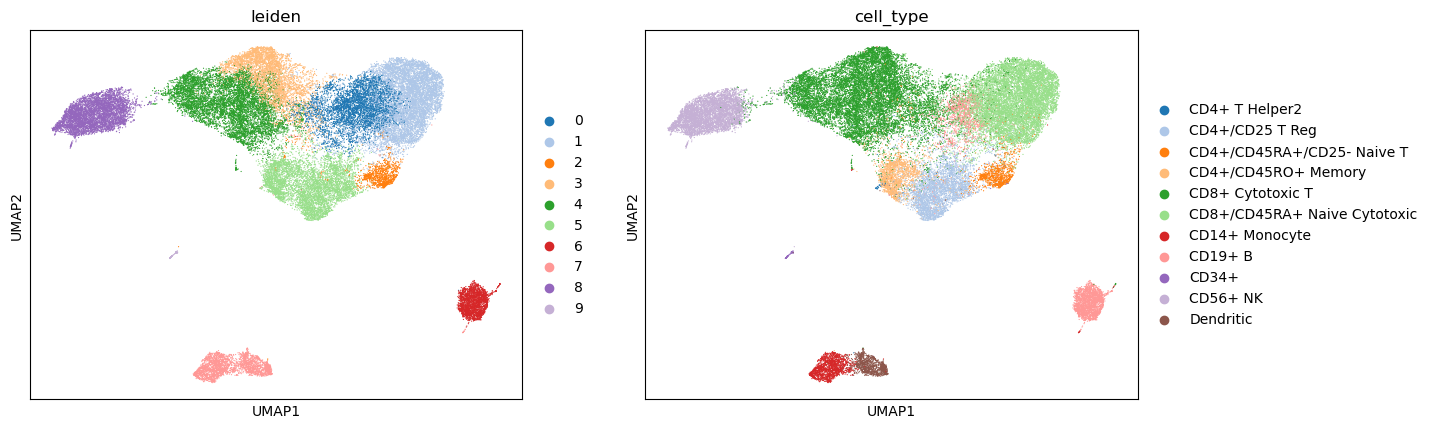

In [15]:
sc.pl.umap(data_dict["pbmc_68k_3khvg_split_train.h5ad"],color=["leiden", "cell_type"])

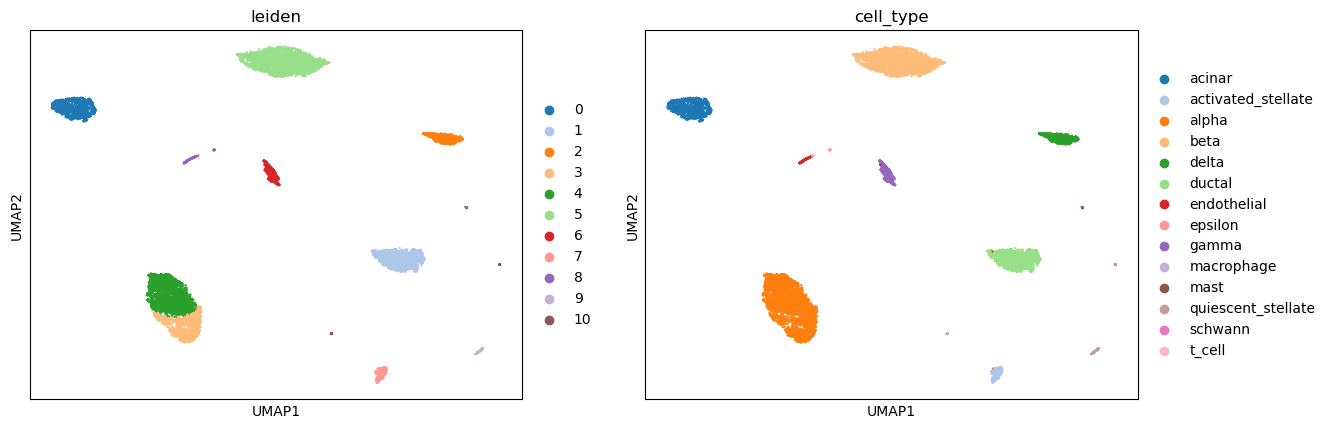

In [16]:
sc.pl.umap(data_dict["pancreas_3khvg_split_train.h5ad"],color=["leiden", "cell_type"])

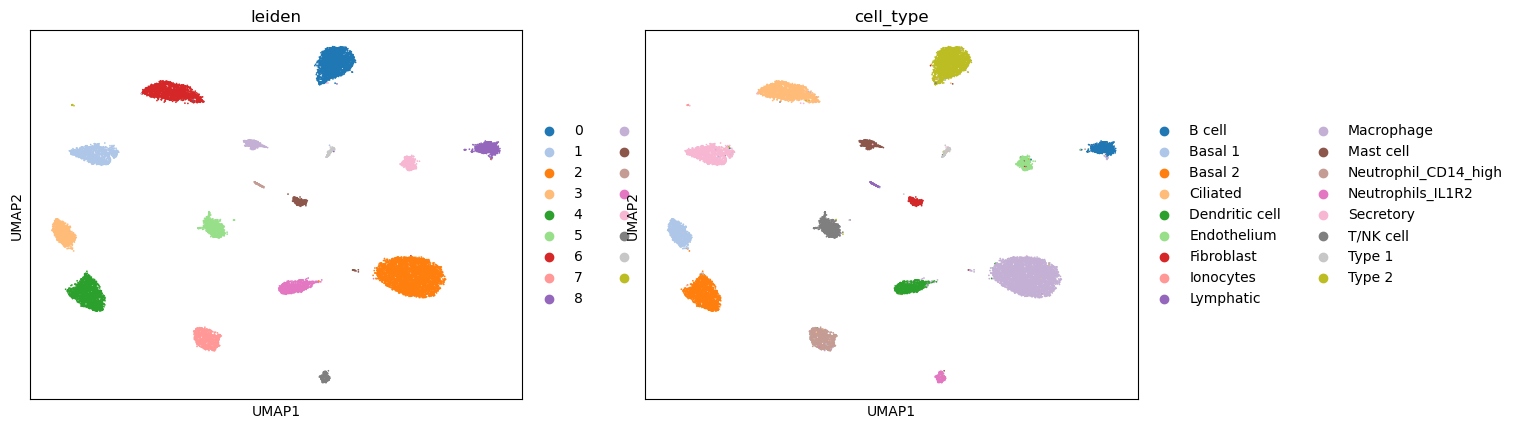

In [17]:
sc.pl.umap(data_dict["lung_3khvg_split_train.h5ad"],color=["leiden", "cell_type"])

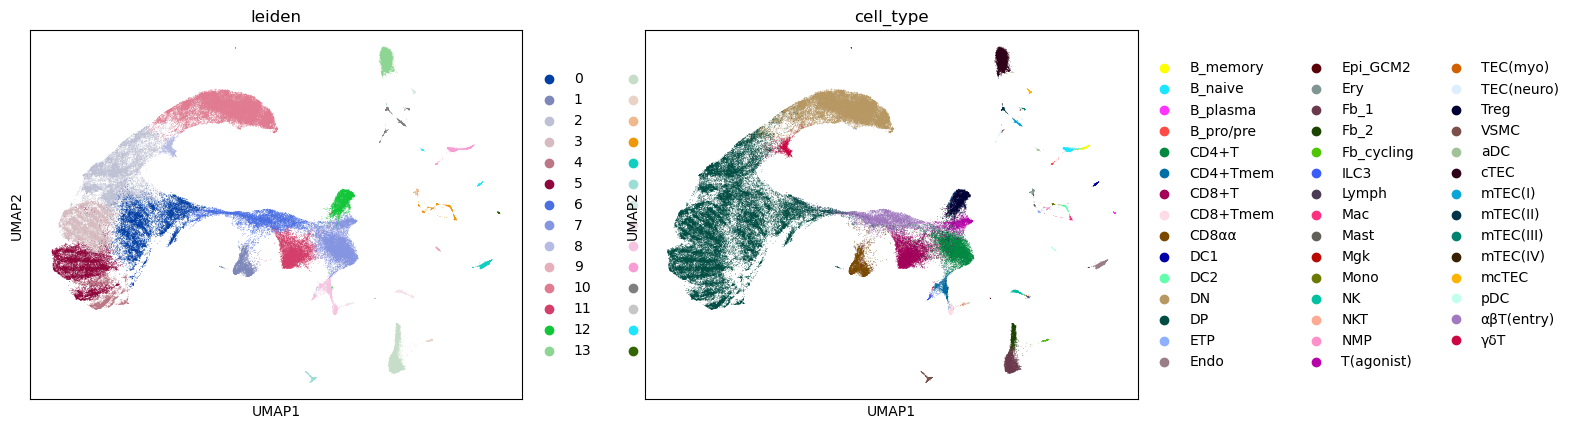

In [18]:
sc.pl.umap(data_dict["thymus_3khvg_split_train.h5ad"],color=["leiden", "cell_type"])

In [19]:
# fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
# sc.pl.umap(data_dict["pbmc_68k_3khvg_split_train.h5ad"],color=["cell_type"],show=False, ax=axs[0,0],legend_loc="none",title="PBMC")
# sc.pl.umap(data_dict["pancreas_3khvg_split_train.h5ad"],color=["cell_type"],show=False, ax=axs[0,1],legend_loc="none",title="Pancreas")
# sc.pl.umap(data_dict["lung_3khvg_split_train.h5ad"],color=["cell_type"],show=False, ax=axs[1,0],legend_loc="none",title="Lung")
# sc.pl.umap(data_dict["thymus_3khvg_split_train.h5ad"],color=["cell_type"],show=False, ax=axs[1,1],legend_loc="none",title="Thymus")
# for ax in axs.reshape(-1):
#     ax.set_axis_off()
    

# fig.savefig("./figures/umap_scvqc.eps")
# fig.savefig("./figures/umap_scvqc.pdf")
# fig.savefig("./figures/umap_scvqc.png",dpi=600)

In [20]:
# fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
# sc.pl.umap(data_dict["pbmc_68k_3khvg_split_train.h5ad"],color=["cell_type"],show=False, ax=axs,legend_loc="none",title="Split-VQ")
# axs.set_axis_off()
# fig.savefig("./figures/umap_split_vq.eps")
# fig.savefig("./figures/umap_split_vq.pdf")
# fig.savefig("./figures/umap_split_vq.png",dpi=600)

In [22]:
adata = data_dict["pbmc_68k_3khvg_split_train.h5ad"]
labels = adata.obs['cell_type'].cat.codes
feature_spectrum = cal_feat_spe(adata.obsm["encoding_indices"],labels)

Feature spectrum shape:  (11, 200)


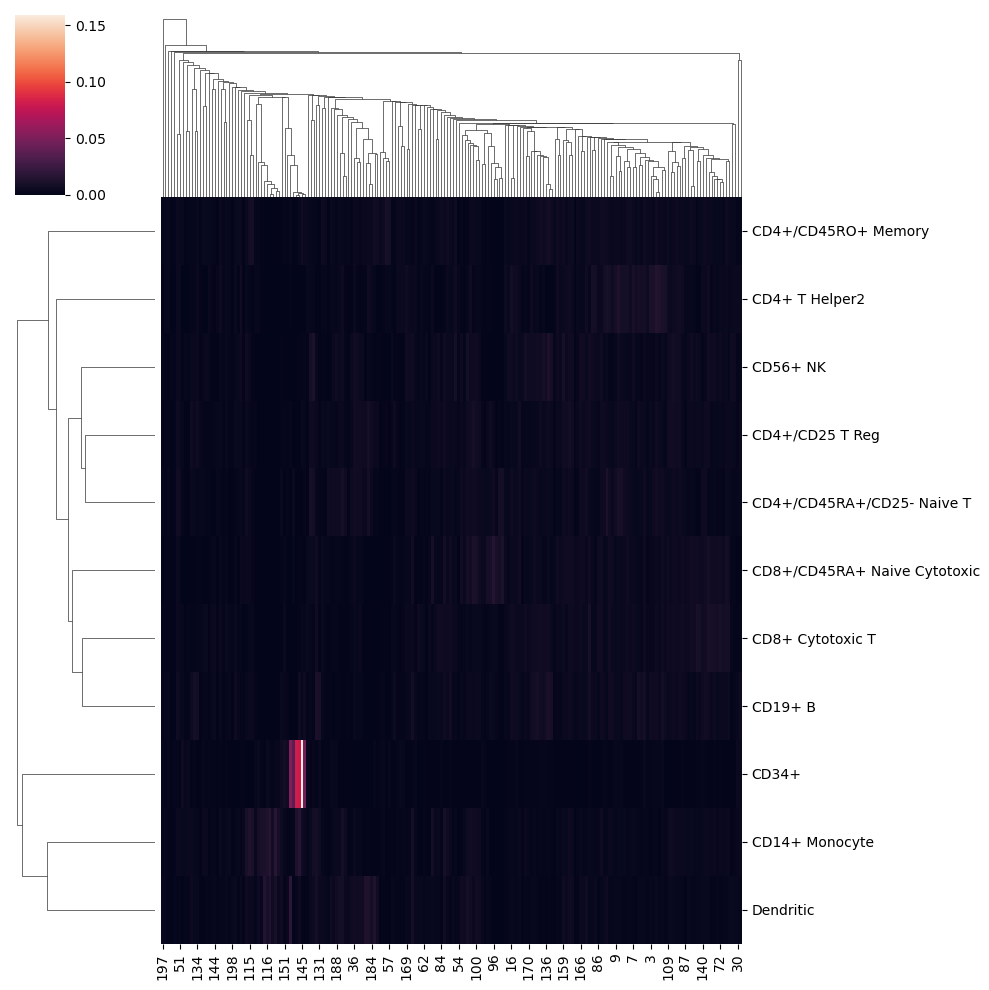

In [55]:
df = pd.DataFrame(feature_spectrum)
df=df.set_index(adata.obs['cell_type'].cat.categories)
sns.clustermap(df,method="single",metric="correlation")
# sns.heatmap(feature_spectrum, yticklabels=adata.obs['cell_type'].cat.categories)

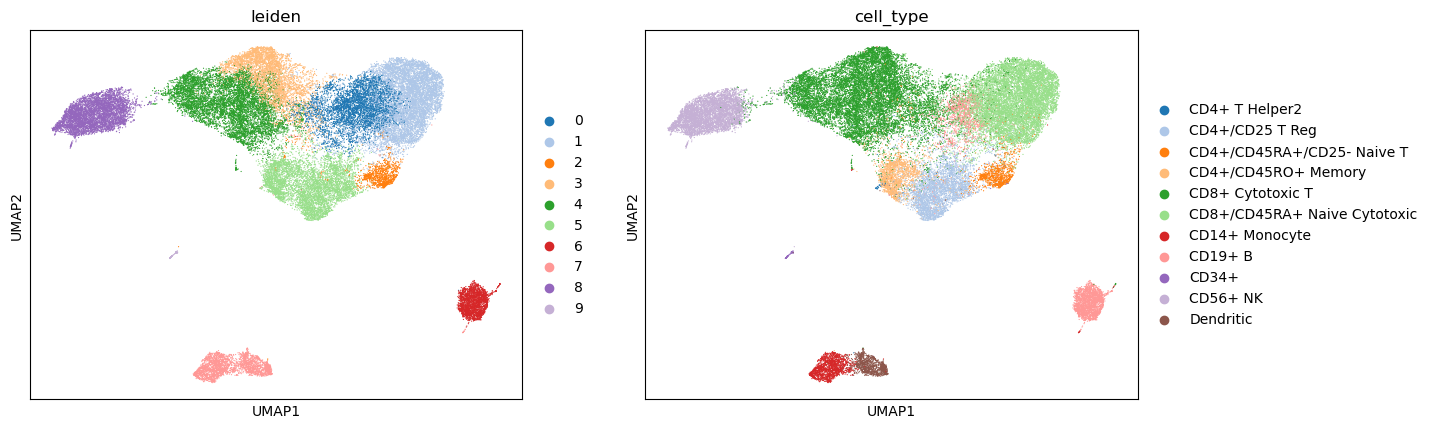

In [24]:
sc.pl.umap(data_dict["pbmc_68k_3khvg_split_train.h5ad"],color=["leiden", "cell_type"])

In [25]:
adata.obs['cell_type'].cat.categories

Index(['CD4+ T Helper2', 'CD4+/CD25 T Reg', 'CD4+/CD45RA+/CD25- Naive T',
       'CD4+/CD45RO+ Memory', 'CD8+ Cytotoxic T',
       'CD8+/CD45RA+ Naive Cytotoxic', 'CD14+ Monocyte', 'CD19+ B', 'CD34+',
       'CD56+ NK', 'Dendritic'],
      dtype='object')

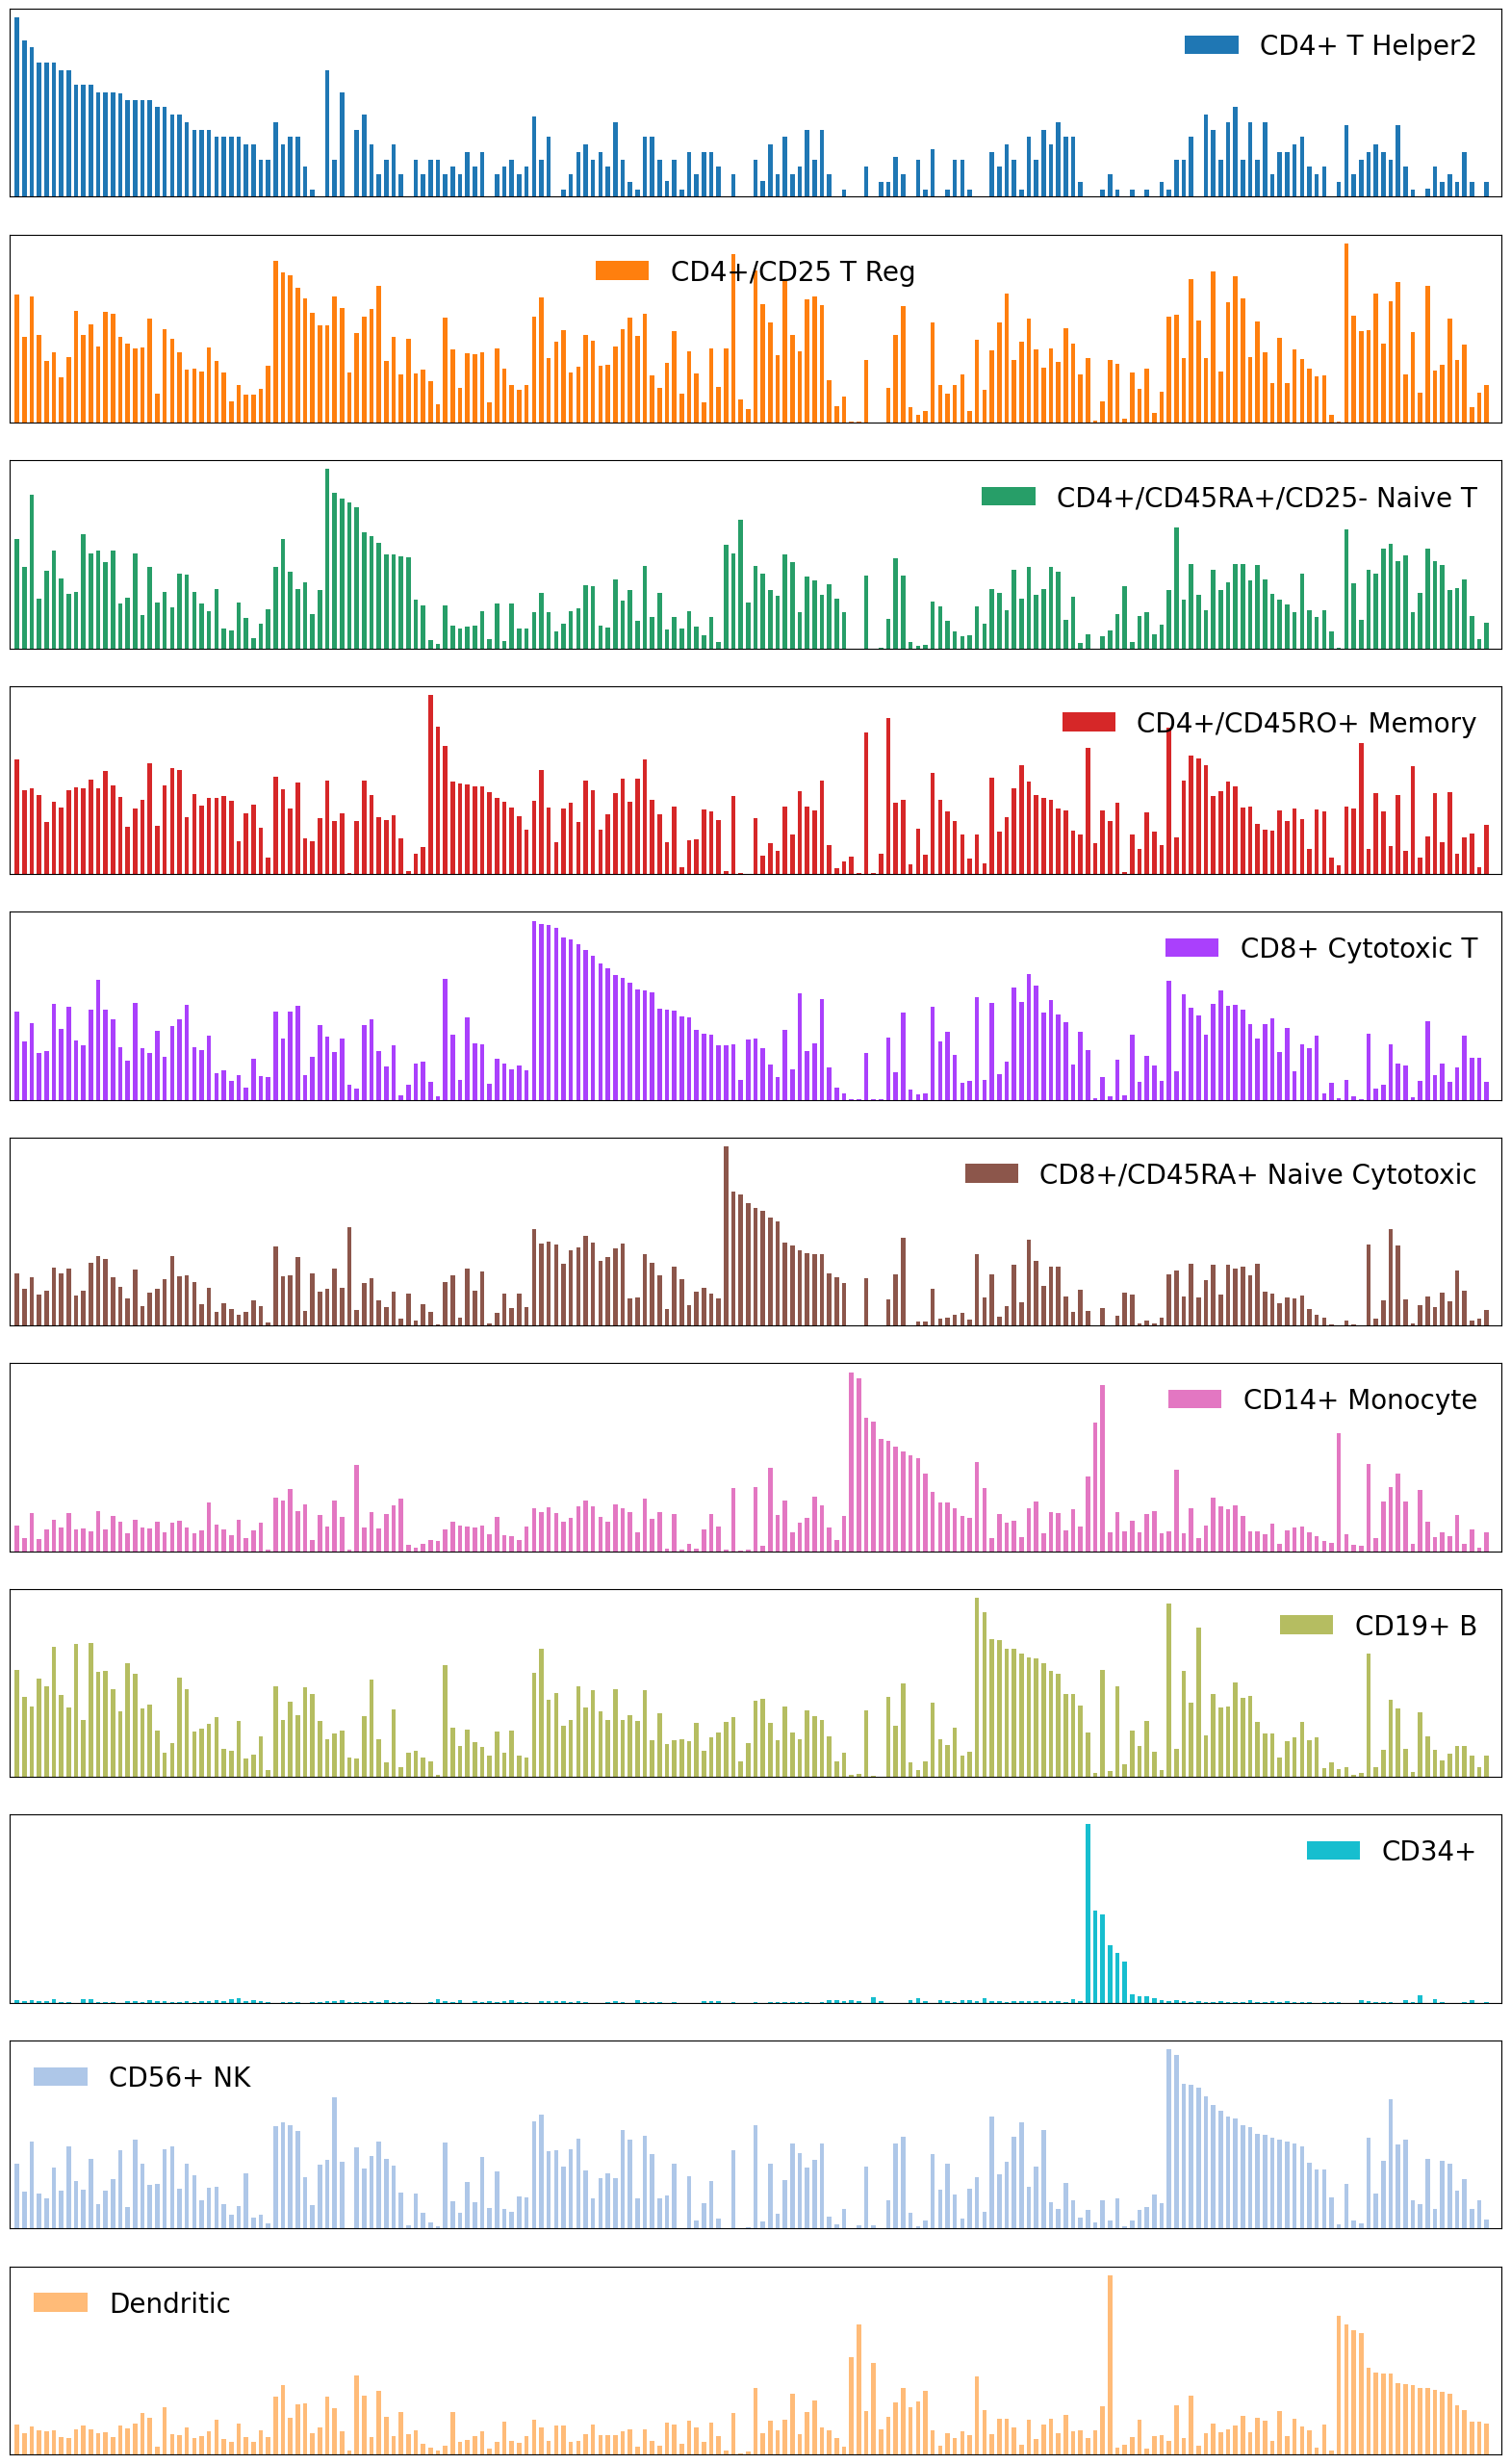

In [46]:
n_index = int(np.max(adata.obsm["encoding_indices"]+1))

n_class= len(np.unique(adata.obs['cell_type'].cat.codes))

colors = ['#1f77b4','#ff7f0e','#279e68','#d62728','#aa40fc','#8c564b','#e377c2','#b5bd61','#17becf','#aec7e8',
          '#ffbb78','#98df8a','#ff9896','#c5b0d5','#c49c94','#f7b6d2','#dbdb8d','#9edae5','#ad494a','#8c6d31']
f,axs = plt.subplots(nrows=n_class,ncols=1,figsize=(20, 3*n_class),sharex=True)
for i in np.unique(adata.obs['cell_type'].cat.codes):
    ax=axs[i]
    cell_type = adata.obs['cell_type'].cat.categories[i]
    ylim = np.max(feature_spectrum[i])
    ax.bar(np.arange(n_index), feature_spectrum[i], width=0.6, color=colors[i], label=cell_type)
    ax.tick_params(axis='both',          
    which='both',      
    bottom=False,      
    left=False,         
    labelbottom=False,
    labelleft =False)
    ax.set_xlim([-1,n_index+1])
    ax.legend(fontsize=20, frameon=False)
#     plt.xlim([0, n_index]);
#     # plt.ylim([0, ylim]);
#     plt.xticks([]);plt.yticks([]);plt.legend(fontsize=20, frameon=False)
#     ax = plt.gca();ax.spines['left'].set_color('none');ax.spines['right'].set_color('none');ax.spines['top'].set_color('none')
#     plt.show()
f.savefig("./figures/feature_spectrum.eps")
f.savefig("./figures/feature_spectrum.pdf")

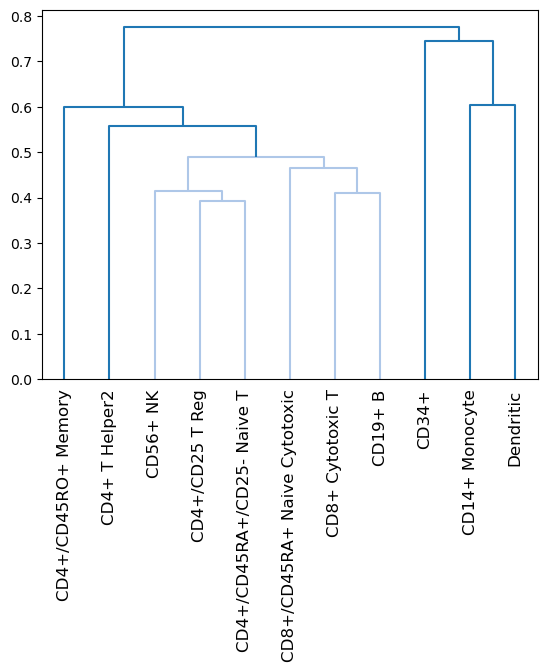

In [67]:
from scipy.cluster.hierarchy import dendrogram, linkage
z = linkage(feature_spectrum,method="single",metric="correlation")
ax=dendrogram(z,labels=adata.obs['cell_type'].cat.categories,leaf_rotation=90)


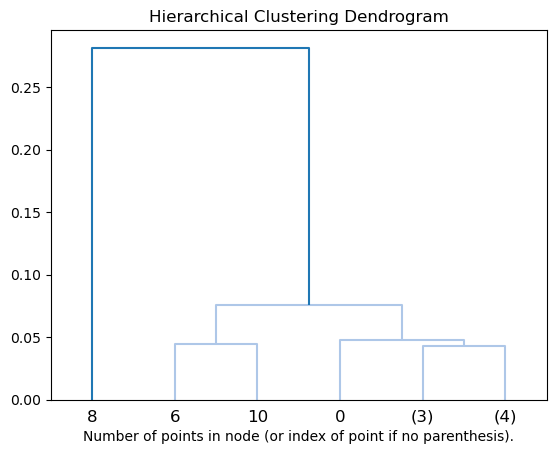

In [56]:
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(feature_spectrum)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
key = 'model_thymus_3khvg_split_train_fsq:False_ema:True_supervised:True_encoder:(1024-256-100)_num_codes:200_split:20_commitment_cost:0.25_n_epochs:5_lr:0.0005.pt'
model = model_dict[key]
data_path = key.split(":", 1)[0]
data_path = data_path.replace("model_", "").replace("train_fsq", "train") + ".h5ad"
adata = data_dict[data_path]
X_train = adata.X
if scipy.sparse.issparse(X_train):
        X_train = X_train.toarray()
with torch.no_grad():
    model.eval()
    _, model_quantized, encoding_indices = model.embed(
            torch.tensor(X_train, dtype=torch.float32).to(device)
        )
    adata.obsm["X_emb_quantized"] = model_quantized.detach().cpu().numpy()
    adata.obsm["encoding_indices"] = encoding_indices.detach().cpu().numpy()
    #     adata.obsm["X_emb"] = model_embedding.detach().cpu().numpy()
    

In [ ]:
use_rep = "X_emb_quantized"
sc.pp.neighbors(adata,use_rep=use_rep)
sc.tl.leiden(adata, flavor="igraph", resolution= 0.5, n_iterations=2)
sc.tl.umap(adata,min_dist=0.1)

In [ ]:
ari_res ={}
ami_res ={}
calinski_harabasz_scores ={}
for (key, adata) in data_dict.items():
    print(key)
    labels_true = adata.obs.cell_type
    labels_pred= adata.obs.leiden
    ari = metrics.adjusted_rand_score(labels_true, labels_pred)
    ami = metrics.adjusted_mutual_info_score(labels_true, labels_pred)
    calinski_harabasz=metrics.calinski_harabasz_score(adata.X.A, labels_pred)
    print(ari)
    print(ami)
    print(calinski_harabasz)

    ari_res[key] = ari
    ami_res[key] = ami
    calinski_harabasz_scores[key] = calinski_harabasz